# Problem Description

Given an image of a fashion item, build a deep learning model that recognizes the fashion item. You must use at least 2 different architectures, one with MLPs and one with CNNs. Use the Fashion-MNIST dataset to train and evaluate your models. More information about the task and the dataset can be found at https://github.com/zalandoresearch/fashion-mnist. The dataset is also available from Tensorflow.

## 

# Imports

In [2]:
import gc

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPool2D, BatchNormalization # Layers to be used for building our model
from tensorflow.keras.models import Model # The class used to create a model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import backend as K
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import EarlyStopping

from typing import List, Dict, Optional, Tuple, Any, Union

import wandb
from wandb.keras import WandbCallback

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


# Weights & Biases

In order to make experiment tracking easier we will use [Weights & Biases](wandb.ai/home), which offers a free lisence for academic purposes. For the sake of this assignment a team has been created:https://wandb.ai/aueb. Access can be granted by contacting the authors.

* Note that this code assumes that you have already set up a Wandb account and API key. If you haven't done so yet, you will need to sign up for a free account at https://wandb.ai/ and follow the instructions there to obtain your API key.



In [4]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Load the data

The dataset can be downloaded directly through [keras.datasets](https://keras.io/api/datasets/fashion_mnist/) which returns a Tuple of NumPy arrays: `(X_train, y_train), (X_test, y_test)`. The Label-description mapping is presented below:

| Label | Description   |
|-------|---------------|
| 0     | T-shirt/top   |
| 1     | Trouser       |
| 2     | Pullover      |
| 3     | Dress         |
| 4     | Coat          |
| 5     | Sandal        |
| 6     | Shirt         |
| 7     | Sneaker       |
| 8     | Bag           |
| 9     | Ankle boot    |

This part of the project will use MLPs, thus the data is flattened into 784 vectors. Moreover, the data will be converter to 

In [5]:
classes: int = 10
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(60000, 784).astype('float32') / 255
X_test = X_test.reshape(10000, 784).astype('float32') / 255
Y_train = to_categorical(y_train, classes)
Y_test = to_categorical(y_test, classes)

4422102/4422102 [==============================] - 0s 0us/step


## Globals



In [6]:
class_names: List[str] = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
label_mapping: dict = dict(zip(list(range(10)), class_names))

# Visualize 

Before proceeding we will visualize a sample of the images. One image from each category is shown.

In [167]:
def plot_mnist(X_train: np.ndarray, 
               y_train: np.ndarray,
               class_names: List[str],
               n_rows: int=2,
               n_cols: int=5,
               figsize: Tuple[int]=(10, 6),
               y: float=0.9
              ) -> None:  
    """Print a sample of unique images given a train set (X and y) along with the label names"""
    
    # Select 10 random samples with unique labels
    idx = []
    while len(idx) < len(class_names):
        i = np.random.randint(len(X_train))
        if y_train[i] not in idx:
            idx.append(y_train[i])
    
    # Create to n_rowsxn_cols plot
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
    for i, ax in enumerate(axes.flat):

        # plot image
        ax.imshow(X_train[y_train == idx[i]][0].reshape(28,28), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

        # add label
        ax.set_xlabel(class_names[idx[i]], fontsize=12)

    plt.suptitle(f"{len(class_names)} Random (Unique) Samples from Training Set", 
                 fontsize=16,
                 y=y)
    plt.tight_layout()
    _ = plt.show()

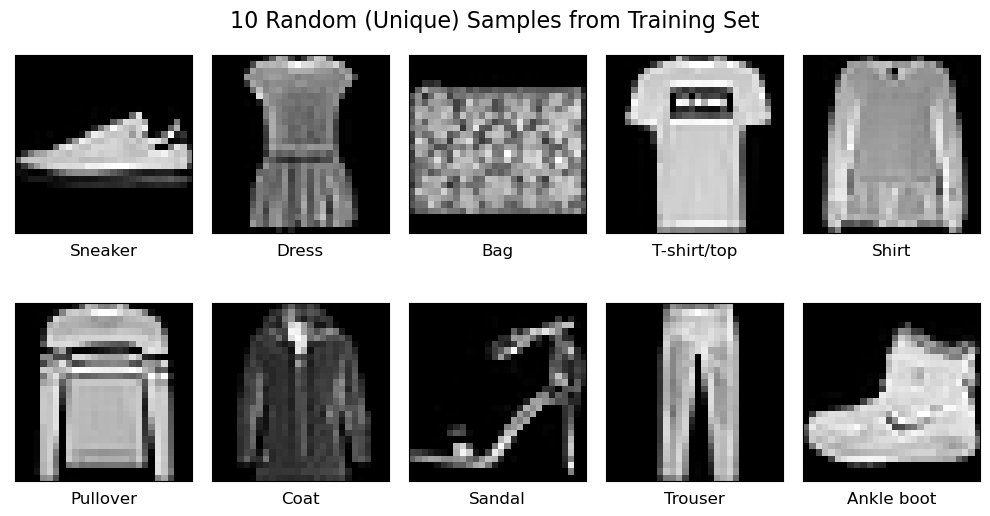

In [171]:
plot_mnist(X_train=X_train, y_train=y_train, class_names=class_names)

We wil also see if the lables are balanced:

In [172]:
def plot_label_freq(y_train: np.ndarray,
                    y_test:  np.ndarray,
                    normalize: bool=True,
                    figsize: Tuple[int]=(10, 6),) -> None:
    
    # Get unique labels and their frequency in train and test sets
    labels, train_freq = np.unique(y_train, return_counts=True)
    _, test_freq = np.unique(y_test, return_counts=True)

    if normalize:
        train_freq = train_freq/len(y_train)
        test_freq = test_freq/len(y_test)
    # Plot side-by-side bar chart
    fig, ax = plt.subplots(figsize=figsize)
    bar_width = 0.35
    opacity = 0.8
    index = np.arange(len(labels))
    train_bars = ax.bar(index, train_freq, bar_width,
                    alpha=opacity,
                    color='#4E79A7',
                    label='Train')
    test_bars = ax.bar(index + bar_width, test_freq, bar_width,
                    alpha=opacity,
                    color='#F28E2B',
                    label='Test')

    # Add labels and ticks
    ax.set_xlabel('Labels')
    ax.set_ylabel('Frequency')
    ax.set_title('Label Frequency (normalized) in Train and Test Sets', fontsize=16)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(labels)
    ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), title="Label")
    plt.tight_layout()
    _ = plt.show()


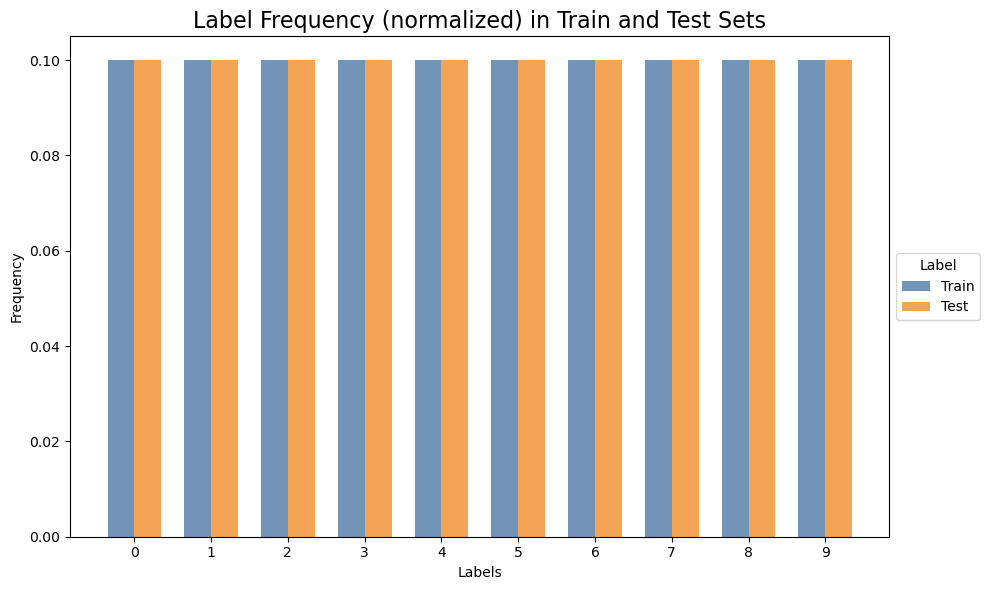

In [173]:
plot_label_freq(y_train=y_train, y_test=y_test)

# Multilayer Perceptron (MLP)

In this part of the assignmed we will evaluate the performance of an MLP architecture. 

* We will first build a Logistic Regression model which will e used as a bseline. 
* From there we will add some hidden layers (by keeping the same parameters) 
* Based on the results we get we will chose one model which we will try to further optimize.

Experiments will be tracked in wandb, thus no plots will be presented in this report. 

## Cleanup

In [174]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

## Build Model

The `train_model` function will be used as the code function which will build the models needed for each step. 

In [ ]:
def train_model(
        train_data: np.ndarray,
        train_labels: np.ndarray,
        optimizer: tf.keras.optimizers,
        epochs: int = 5,
        batch_size: int = 128,
        hidden_layers: List[int] = [],
        hidden_activation: str = 'relu',
        output_activation: str = 'softmax',
        verbose: int = 0, 
        callbacks: Optional[List[Any]] = None, 
        dropout: Optional[float] = None,
        batch_norm: bool = False) -> tuple:
    
    np.random.seed(42) # Define the seed for numpy to have reproducible experiments.
    set_seed(42) # Define the seed for Tensorflow to have reproducible experiments.
    
    # Define the input layer.
    _input = Input(
        shape=(784,),
        name='Input'
    )

    x = _input
    # Define the remaining hidden layers.
    for i, units in enumerate(hidden_layers):
        x = Dense(
            units=units,
            kernel_initializer='glorot_uniform',
            activation=hidden_activation,
            name='Hidden-{0:d}'.format(i + 1)
        )(x)
        if batch_norm & i > 0:
            x = BatchNormalization()(x)
        if dropout:
            if i > 0:
                dropout=0.2
            x = Dropout(
                rate=dropout,
                name='Dropout-{0:d}'.format(i + 1)
            )(x)
        
    # Define the output layer.
    output = Dense(
        units=classes,
        kernel_initializer='glorot_uniform',
        activation=output_activation,
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=_input, outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    hs = model.fit(
        x=X_train,
        y=Y_train,
        validation_split=0.1, # use 10% of the training data as validation data
        epochs=epochs,
        verbose=verbose,
        callbacks=callbacks,
        batch_size=batch_size
    )
    print('Finished training.')
    print('------------------')
    model.summary() # Print a description of the model.
    return model, hs

### Model variables & Functions

the function `opt_es` will be used to return the optimizer and the early_stopping object for the sake of simplicity.

In [175]:
epochs: int = 100

def opt_es(learning_rate=0.001, monitor='val_accuracy', patience=15) -> tuple:
    """return the Adam optimizer and the readly stopping"""
    optimizer = Adam(learning_rate=learning_rate)
    early_stopping = EarlyStopping(
            monitor=monitor,
            patience=patience,
            verbose=1,
            restore_best_weights=True
        )
    return optimizer, early_stopping

In [176]:
def print_eval(hs, _eval) -> None:
    """Prints Train, validation and test metrics for an input hs object"""
    
    print("Train Loss     : {0:.5f}".format(hs.history['loss'][-1]))
    print("Validation Loss: {0:.5f}".format(hs.history['val_loss'][-1]))
    print("Test Loss      : {0:.5f}".format(_eval[0]))
    print("---")
    print("Train Accuracy     : {0:.5f}".format(hs.history['accuracy'][-1]))
    print("Validation Accuracy: {0:.5f}".format(hs.history['val_accuracy'][-1]))
    print("Test Accuracy      : {0:.5f}".format(_eval[1]))

### Baseline model (Logistic regression)

In [ ]:
wandb.init(project="Deep_Learning_1", 
           name="MLP_baseline")


optimizer, early_stopping = opt_es()
# Logistic Regression
lr_model, lr_hs = train_model(
    train_data=X_train,
    train_labels=Y_train,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=128,
    hidden_layers=[],
    hidden_activation='relu',
    output_activation='softmax',
    callbacks=WandbCallback()
)

# Evaluate on test data and show all the results.
lr_eval = lr_model.evaluate(X_test, Y_test, verbose=1)
print_eval(lr_hs, lr_eval)
clean_up(model=lr_model)
wandb.finish()

### Add hidden layers

We will add 1 and 2 hidden layers respactively to see the behaviour of the model. The dimensions will be:
* [256]
* [512, 256]

In [ ]:
for i, hidden_layers in enumerate([[256], [512, 256]]):
    wandb.init(project="Deep_Learning_1", 
               name=f"MLP_layers_{i+1}")

    optimizer, early_stopping = opt_es()
    # train model
    model, hs = train_model(
        train_data=X_train,
        train_labels=Y_train,
        optimizer=optimizer,
        epochs=50,
        batch_size=64,
        hidden_layers=hidden_layers,
        hidden_activation='relu',
        output_activation='softmax',
        callbacks=[WandbCallback(), early_stopping]
    )

    # Evaluate on test data and show all the results.
    _eval = model.evaluate(X_test, Y_test, verbose=1)
    print_eval(hs, _eval)
    clean_up(model=model)
    wandb.finish()

### First comments on the results

It looks like by adding a hidden layer the model suffers from overfitting. This can be seen by comparing the training loss (loss in wandb) to the validation loss (val_loss in wandb).
Moreover, it seems that there isn't much of an advantage when adding two hidden layers, compared to one.

We will try to fix these issues, and improve the performance, by performing various optimizations, like:
* Using regularization techniques
* Introduce early stopping
* Add dropout and/or batch normalization
* Add data augmentation
* Reduce the size of the hidden layer
* Optimize hyper-parameters


### Sweeps for Hypter-parameter tuning

* In order to keep the code short, we will present the sweep configuration in this cell and run the cells below, by over-writting the output.

#### [First Sweep](https://wandb.ai/aueb/MLP_Sweep/sweeps/m6zric3t?workspace=user-gchalkiopoulos)
```
sweep_configuration = {
    'method': 'bayes',
    'name': 'sweep',
    'metric': {
        'goal': 'minimize', 
        'name': 'val_loss'
        },
    'parameters': {
        'batch_size': {'values': [16, 32, 64, 128, 256]},
        'dropout': {'values': [0.2, 0.3, 0.4, 0.5]},
        'learning_rate': {'values': [0.0001, 0.0005, 0.001]},
        'hidden_layers': {'values': [128, 256, 512]},
#         'epochs': {'values': [100]}     
    }
}
```
The results from the sweep configuration idicate that we should keep the learning rate low (0.001) and the hidden layers relatively high (drop the 128). Moreover, it seems that the model would benefit from an increase in the epochs.

#### [Second Sweep](https://wandb.ai/aueb/MLP_Sweep_2/sweeps/71bf1cbj?workspace=user-gchalkiopoulos)
```
sweep_configuration = {
    'method': 'random',
    'name': 'sweep',
    'metric': {
        'goal': 'minimize', 
        'name': 'val_loss'
        },
    'parameters': {
        'batch_size': {'values': [64, 
                                  128, 
                                  512]},
        'dropout': {'values': [0.4, 
                               0.5, 
                               0.6]},
        'learning_rate': {'values': [0.0001]},
        'hidden_layers': {'values': [[512], [1024], 
                                     [2048, 256], 
                                     [1024, 128]]},
        'epochs': {'values': [300]}, 
        'batch_nrorm': {'values': [True, False]}
    }
}
```

As seen from the results, the improvement is not significant. We were able to overcome the overfitting of the more complex models by increasing the dropout rate, using a small learning rate and adding batch normalization. Nevertheless, the model seem to reach a plateau at around 90% accuracy. For the sake of this assignment, we will consider the results satisfactory and use all the data to train the best model (considering the validation loss and accuracy).

In [ ]:
sweep_configuration = {
    'method': 'random',
    'name': 'sweep',
    'metric': {
        'goal': 'minimize', 
        'name': 'val_loss'
        },
    'parameters': {
        'batch_size': {'values': [64, 
                                  128, 
                                  512]},
        'dropout': {'values': [0.4, 
                               0.5, 
                               0.6]},
        'learning_rate': {'values': [0.0001]},
        'hidden_layers': {'values': [[512], [1024], 
                                     [2048, 256], 
                                     [1024, 128]]},
        'epochs': {'values': [300]}, 
        'batch_nrorm': {'values': [True, False]}
    }
}

# Initialize sweep by passing in config. (Optional) Provide a name of the project.
sweep_id = wandb.sweep(sweep=sweep_configuration, project='MLP_Sweep_2')


def main():
    
    run = wandb.init()

    optimizer = Adam(learning_rate=wandb.config.learning_rate)

    # Logistic Regression
    lr_model_sgd, lr_hs_sgd = train_model(
        train_data=X_train,
        train_labels=Y_train,
        optimizer=optimizer,
        epochs=wandb.config.epochs,
        batch_size=wandb.config.batch_size,
        hidden_layers=wandb.config.hidden_layers,
        hidden_activation='relu',
        output_activation='softmax',
        callbacks=[WandbCallback(), early_stopping],
        dropout=wandb.config.dropout, 
        batch_norm=wandb.config.batch_nrorm

    )

    # Evaluate on test data and show all the results.
    lr_eval_sgd = lr_model_sgd.evaluate(X_test, Y_test, verbose=1)
    clean_up(model=lr_model_sgd)


In [ ]:
wandb.agent(sweep_id, function=main, count=25)
wandb.finish()

## Load best model and predict on test set

Having performed a large number of runs, we will stop further exploration, since the results don't seem to improve dramatically.

In [7]:
# load the best model
api = wandb.Api()
artifact = api.artifact('aueb/MLP_Sweep_2/model-youthful-sweep-13:v72', type='model')
artifact.download()
artifact_model = tf.keras.models.load_model("./artifacts/model-youthful-sweep-13:v72")

print(artifact_model.summary())

# evaluate
_eval = artifact_model.evaluate(X_test, Y_test)
print("---")
print("Test Loss      : {0:.5f}".format(_eval[0]))
print("---")
print("Test Accuracy      : {0:.5f}".format(_eval[1]))

wandb:   5 of 5 files downloaded.  


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 784)]             0         
                                                                 
 Hidden-1 (Dense)            (None, 1024)              803840    
                                                                 
 Dropout-1 (Dropout)         (None, 1024)              0         
                                                                 
 Output (Dense)              (None, 10)                10250     
                                                                 
Total params: 814,090
Trainable params: 814,090
Non-trainable params: 0
_________________________________________________________________
None
313/313 [==============================] - 4s 3ms/step - loss: 0.2921 - accuracy: 0.9008
---
Test Loss      : 0.29207
---
Test Accuracy      : 0.90080


## Evaluate results

In [8]:
def plot_confusion_matrix(confusion_matrix, 
                          classes, 
                          normalize=False, 
                          title='Confusion matrix', 
                          cmap=plt.cm.YlGnBu) -> None:
    """
    This function plots a confusion matrix using Matplotlib.

    Parameters:
    confusion_matrix (numpy.ndarray): The confusion matrix to plot.
    classes (list): The list of class names to display on the x and y axes.
    normalize (bool): A Boolean value that indicates whether to normalize the values in the confusion matrix.
    title (str): The title of the plot.
    cmap (matplotlib.colors.Colormap): The color map to use for the plot.

    Returns:
    None
    """
    
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, [f"{i}: {class_name}" for i, class_name in enumerate(class_names)], rotation=45)
    plt.yticks(tick_marks, [f"{i}: {class_name}" for i, class_name in enumerate(class_names)])
    
    fmt = '.2f' if normalize else 'd'
    thresh = confusion_matrix.max() / 2.
    
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(j, i, format(confusion_matrix[i, j], fmt),
                     ha='center', va='center',
                     color='white' if confusion_matrix[i, j] > thresh else 'black')
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


### Confusion Matrix

313/313 [==============================] - 1s 2ms/step


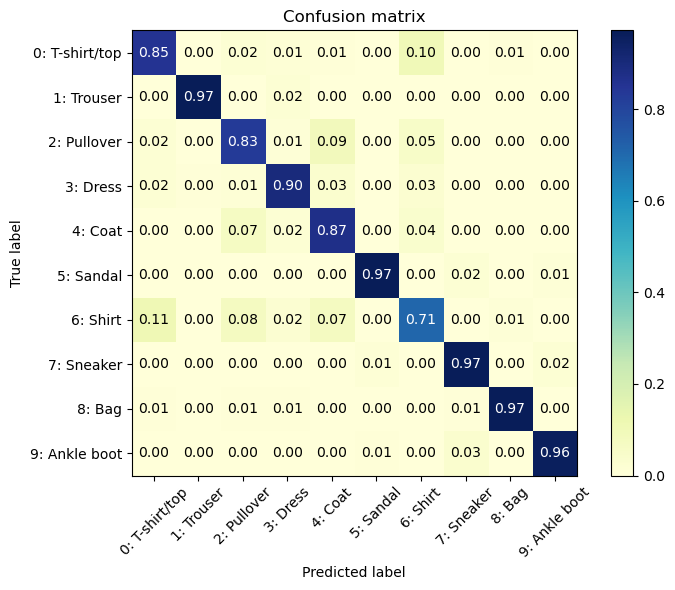

In [9]:
# Make predictions on the test set
y_pred = artifact_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(Y_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

plot_confusion_matrix(cm, classes=class_names, normalize=True)

### Classification report

In [86]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, support = precision_recall_fscore_support(y_true_classes, y_pred_classes, average=None)

print(f"{'':<12} | {'Precision':<10} | {'Recall':<10} | {'F1-score':<10} | {'Support':<10}")
for i, label in enumerate(class_names):
    print(f"{label:<12} | {precision[i]:<10.2f} | {recall[i]:<10.2f} | {f1[i]:<10.2f} | {support[i]:<10.2f}")


             | Precision  | Recall     | F1-score   | Support   
T-shirt/top  | 0.85       | 0.85       | 0.85       | 1000.00   
Trouser      | 0.99       | 0.97       | 0.98       | 1000.00   
Pullover     | 0.82       | 0.83       | 0.83       | 1000.00   
Dress        | 0.91       | 0.90       | 0.90       | 1000.00   
Coat         | 0.81       | 0.87       | 0.84       | 1000.00   
Sandal       | 0.98       | 0.97       | 0.97       | 1000.00   
Shirt        | 0.76       | 0.71       | 0.73       | 1000.00   
Sneaker      | 0.95       | 0.97       | 0.96       | 1000.00   
Bag          | 0.98       | 0.97       | 0.97       | 1000.00   
Ankle boot   | 0.97       | 0.96       | 0.97       | 1000.00   


## Analyze incorrect classifications

As seen from the confusion matrix, the errors happen most often on specific categories. We will explore these classses to get a better understanding of the behaviour of our model.

The `plot_misclassified_images` plots 4 pictures of incorrect classification and 4 pictures of clothes corresponding to the predicted label. This will help us get a better understanding of the errors.

In [65]:
def plot_misclassified_images(images: np.ndarray,
                              true_labels: np.ndarray,
                              predicted_labels: np.ndarray,
                              class_names: List[str],
                              n: int = 8,
                              true_class: int = None,
                              pred_class: int = None) -> None:
    """
    Plots a grid of misclassified images along with their true and predicted labels.

    Args:
        images (np.ndarray): An array of shape (num_images, height, width) containing the image data.
        true_labels (np.ndarray): An array of shape (num_images,) containing the true class labels.
        predicted_labels (np.ndarray): An array of shape (num_images,) containing the predicted class labels.
        class_names (List[str]): A list of strings containing the names of the classes.
        n (int): The number of misclassified images to plot (default is 4).
        true_class (int): If not None, only plot misclassified images where the true class is equal to true_class.
        pred_class (int): If not None, only plot misclassified images where the predicted class is equal to pred_class.
    """
    
    # Get the misclassified images and their true/predicted labels
    misclassified_idx = np.where(true_labels != predicted_labels)[0]
    
    
    if true_class is not None:
        misclassified_idx = np.intersect1d(misclassified_idx, np.where(true_labels == true_class)[0])
    if pred_class is not None:
        misclassified_idx = np.intersect1d(misclassified_idx, np.where(predicted_labels == pred_class)[0])
        
    misclassified_images = images[misclassified_idx[:n]]
    misclassified_true_labels = true_labels[misclassified_idx[:n]]
    misclassified_predicted_labels = predicted_labels[misclassified_idx[:n]]

    # Plot the misclassified images with their true/predicted labels
    fig, axes = plt.subplots(2, 4, figsize=(12, 5))
    for i, ax in enumerate(axes.flat):
        _index = np.random.randint(len(misclassified_true_labels))
        if i < 4:
            ax.imshow(misclassified_images[_index].reshape(28,28), cmap='binary')
            ax.set_title(f"True: {class_names[misclassified_true_labels[_index]]}\nPredicted: {class_names[misclassified_predicted_labels[_index]]}")
        else:
            ax.imshow(images[y_test == pred_class][_index].reshape(28,28), cmap='binary')
            ax.set_title(f"Label: {class_names[pred_class]}")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

### Predicted: Shirt 

As seen from the confusion matrix, the Shirt category has the lowest recall, getting confused with the category T-Shirt/top, as well as the Pullover/Dress and coat.
Looking at the plot below, we can see that this is expected, as many items of the top row (incorrect classifications) are similar to those of the second (pedicted label prictures).

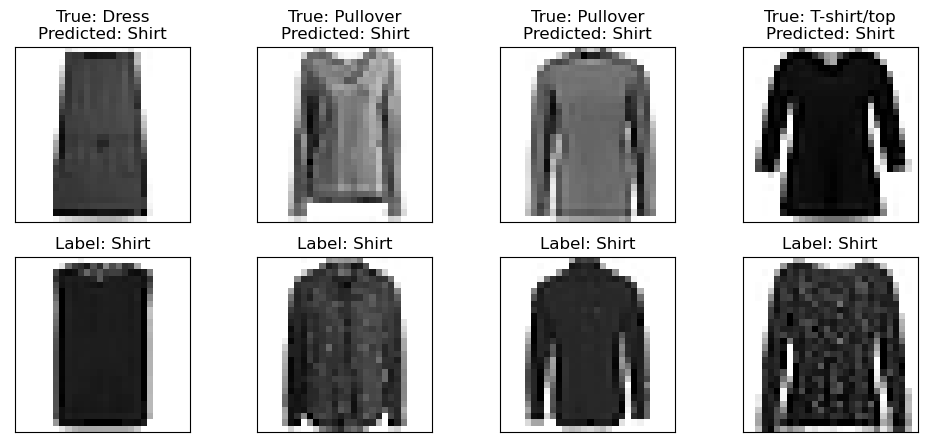

In [66]:
plot_misclassified_images(X_test, y_true_classes, y_pred_classes, class_names, pred_class=6)

### Predicted: T-shirt/top 
Similarly, the T-shirt/top category is often confused with the Shirt one (which makes sense looking ath the image below). 

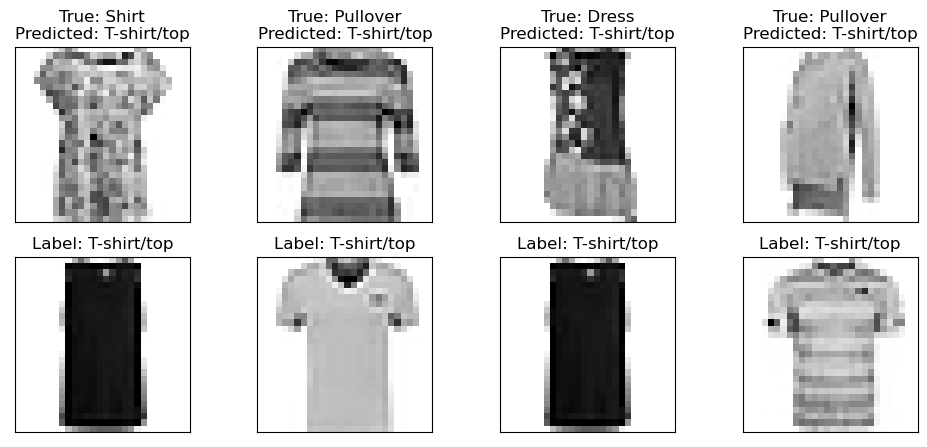

In [68]:
plot_misclassified_images(X_test, y_true_classes, y_pred_classes, class_names, pred_class=0)

### Predicted: Pullover

Pullovers are confused with Coats and Shirts, which can be expected, as seen from the image below.

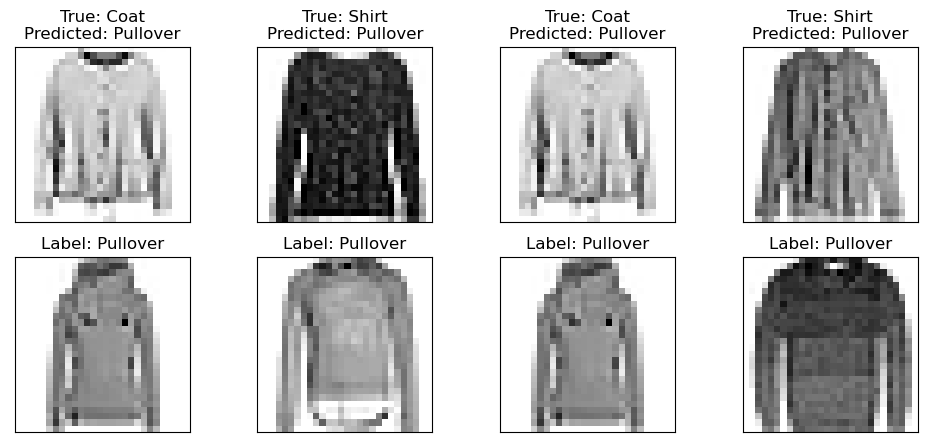

In [89]:
plot_misclassified_images(X_test, y_true_classes, y_pred_classes, class_names, pred_class=2)